In [1]:
import numpy as np
import fenics
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.io as sio
# from fenics_to_scipy_sparse_csr_conversion import convert_fenics_csr_matrix_to_scipy_csr_matrix, vec2fct
from fenics_interactive_impulse_response_plot import fenics_interactive_impulse_response_plot
import matplotlib.pyplot as plt
from fenics_function_smoother import FenicsFunctionSmoother
from fenics_function_fast_grid_evaluator import FenicsFunctionFastGridEvaluator
from mesh_makers import circle_mesh
from random_fenics_function_makers import random_smooth_partition_of_unity, FenicsSmoothFunctionMaker, randn_fenics_function
from plot_ellipse import plot_ellipse
from interpolate_matrices import interpolate_matrices
from make_fenics_amg_solver import make_fenics_amg_solver
from poisson_interpolation import PoissonSquaredInterpolation
from localpsf_helpers import *
from localpsf import *
import hlibpro_wrapper as hpro
from basic_randomized_svd import basic_randomized_svd
from load_angel_peak_badlands_image_into_fenics import load_angel_peak_badlands_image_into_fenics

In [2]:
fine_mesh_h=5e-3
mesh_h= 4e-2 # 1e-2
finite_element_order=1
# final_time_T=5e-4
final_time_T = 5e-2 # 1e-2
num_timesteps=35
noise_level=5e-3
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
num_random_matrices_for_conductivity_field=4
conductivity_interpolation_temperature=3
boundary_tol = 0.5
num_std_dev_tau=3
# a_reg = 1e-4 # Morozov: 4.4 % noise
# a_reg = 5e-5 # Morozov: 2.9 % noise <-- good
# a_reg = 2e-5 # Morozov: 1.7 % noise
a_reg = 1e-5 # Morozov: 1.2 % noise
# a_reg = 1e-6 # Morozov: 0.58 % noise, too small for mesh?
reg_M_scalar = 1e0 # regularization = a_reg * (K + reg_M_scalar*M)

In [3]:
np.random.seed(1)

In [4]:
fine_mesh = circle_mesh(mesh_center, mesh_radius, 1./fine_mesh_h)
fine_V = fenics.FunctionSpace(fine_mesh, 'CG', finite_element_order)

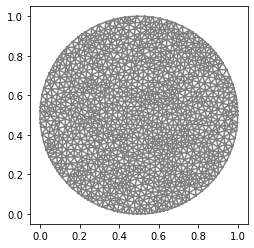

In [5]:
mesh = circle_mesh(mesh_center, mesh_radius, 1./mesh_h)
V = fenics.FunctionSpace(mesh, 'CG', finite_element_order)
fenics.plot(mesh)

X = V.tabulate_dof_coordinates()
N = V.dim()
d = mesh.geometric_dimension()

Make conductivity field $\kappa$ defined by
$$\kappa_{ij}(x) := \sum_{k=1}^4 w_k(x)\left(C_k\right)_{ij}$$
where $C_k$ are randomish matrices and $w_k$ are randomish smooth fields.

We build the functions $w_k$ on a very fine grid that always stays the same for reproducibility, then interpolate them to different coarser grid for different runs/numerical experiments.

In [6]:
fine_ww = random_smooth_partition_of_unity(num_random_matrices_for_conductivity_field, fine_V, 
                                           temperature=conductivity_interpolation_temperature, normalize=True)

In [7]:
for fw in fine_ww:
    fw.set_allow_extrapolation(True)
    
ww = [fenics.interpolate(fw, V) for fw in fine_ww]

In [8]:
C0 = np.array([[0.50,  0.25],
               [0.25,  0.25]])/50
C1 = np.array([[ 0.50, -0.40],
               [-0.40,  0.50]])/50
C2 = np.array([[ 1.70, -0.10],
               [-0.10,  4.10]])/50
C3 = np.array([[ 1.90, -0.25],
               [-0.25,  0.60]])/50
CC = [C0, C1, C2, C3]

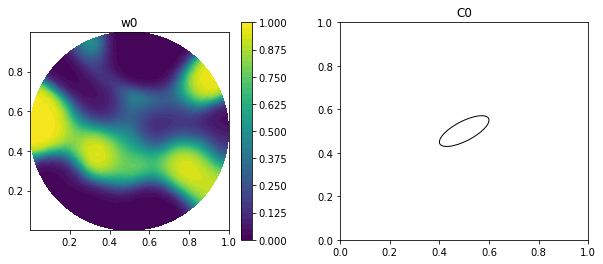

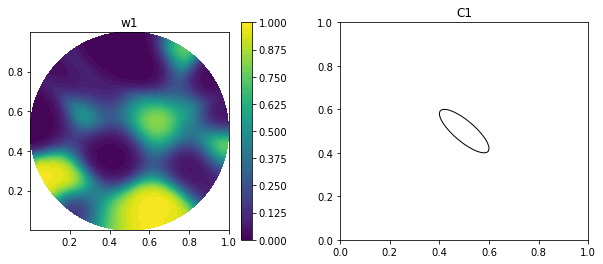

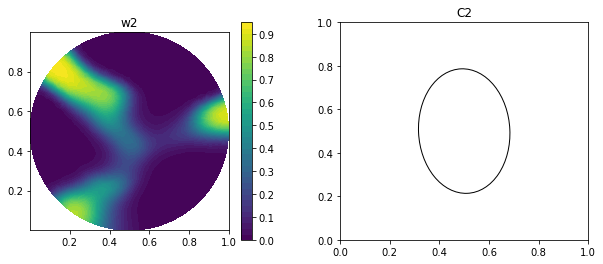

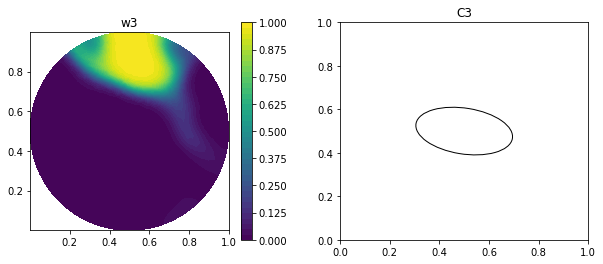

In [9]:
nw = len(ww)
for k in range(nw):
    f = plt.figure()
    f.set_figwidth(10)
    
    plt.subplot(1,2,1)
    c = fenics.plot(ww[k])
    plt.colorbar(c)
    plt.title('w'+str(k))
    
    ax = plt.subplot(1,2,2)
    plot_ellipse(ax, np.array([0.5,0.5]), CC[k], 1.0)
    plt.title('C'+str(k))
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    plt.subplots_adjust(wspace=0.25)

$$u_t = -\nabla \cdot \kappa \nabla u$$
Input at $u(0)$
Observations at $t=T$

In [10]:
kappa = interpolate_matrices(ww, CC)

/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi


Text(0.5, 1.0, 'kappa')

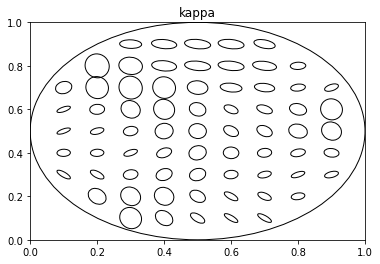

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_ellipse(ax, mesh_center, np.eye(2), mesh_radius)

xx = np.linspace(0., 1., 11)
yy = np.linspace(0., 1., 11)

for ii in range(len(xx)):
    for jj in range(len(yy)):
        mu = np.array([xx[ii], yy[jj]])
        if np.linalg.norm(mu - mesh_center) < mesh_radius:
            Sigma = kappa(np.array(mu)).reshape((2,2))
            plot_ellipse(ax, mu, Sigma, 0.20)
            
plt.title('kappa')

In [12]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)

mass_form = u_trial * v_test * fenics.dx
M = fenics.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

stiffness_form = fenics.inner(kappa * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
A = fenics.assemble(stiffness_form)

In [13]:
delta_t = final_time_T / num_timesteps
Z_minus = M
Z_plus = M + delta_t * A

solve_Z_plus = make_fenics_amg_solver(Z_plus)

Text(0.5, 1.0, 'u0_true')

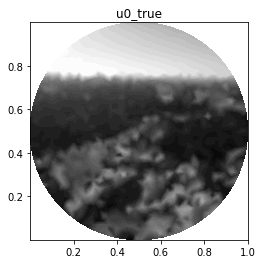

In [14]:
# zz = random_smooth_partition_of_unity(100, V, temperature=10, normalize=True)
# # zz = random_smooth_partition_of_unity(25, V, temperature=10, normalize=True)
#
# u0_true = fenics.Function(V)
# for k in range(len(zz)):
#     u0_true.vector()[:] = u0_true.vector() + (k**2) * zz[k].vector()

u0_true = load_angel_peak_badlands_image_into_fenics(V)
plt.figure()

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

In [15]:
def forward_map(u0_petsc):
    uT_petsc = fenics.Vector(u0_petsc)
    for k in range(num_timesteps):
        uT_petsc = solve_Z_plus(Z_minus * uT_petsc)
    return uT_petsc

Text(0.5, 1.0, 'uT_true')

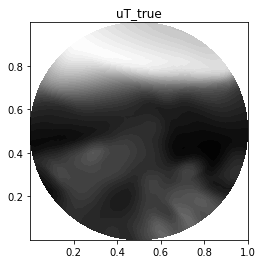

In [16]:
uT_true = fenics.Function(V)
uT_true.vector()[:] = forward_map(u0_true.vector())
fenics.plot(uT_true, cmap='gray')
plt.title('uT_true')

In [17]:
def adjoint_map(vT_petsc):
    v0_petsc = fenics.Vector(vT_petsc)
    for k in range(num_timesteps):
        v0_petsc = Z_minus * solve_Z_plus(v0_petsc)
    return v0_petsc

Perform adjoint correctness check

In [18]:
x = randn_fenics_function(V)
y = randn_fenics_function(V)
adjoint_err = np.abs(forward_map(x.vector()).inner(y.vector())
                     - x.vector().inner(adjoint_map(y.vector())))
print('adjoint_err=', adjoint_err)

adjoint_err= 7.713056859870449e-10


true_noise_level= 0.0048937931511492845


Text(0.5, 1.0, 'uT_obs')

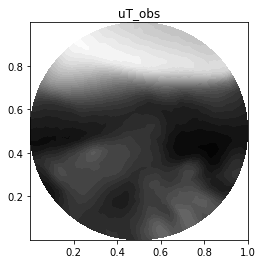

In [19]:
N = V.dim() 
normalized_noise = np.random.randn(N) / np.sqrt(N)
uT_obs = fenics.Function(V)
uT_obs.vector()[:] = uT_true.vector()[:] + noise_level * normalized_noise * np.linalg.norm(uT_true.vector()[:])

true_noise_level = fenics.norm(uT_obs.vector() - uT_true.vector())/fenics.norm(uT_true.vector())
print('true_noise_level=', true_noise_level)
fenics.plot(uT_obs, cmap='gray')
plt.title('uT_obs')

In [20]:
def objective(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    J = 0.5 * discrepancy.inner(M * discrepancy)
    return J

In [21]:
objective(u0_true.vector())

1.530101627865926e-06

In [22]:
def gradient(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    return adjoint_map(M * discrepancy)

In [23]:
def apply_hessian(p_petsc):
    return adjoint_map(M * forward_map(p_petsc))

apply_Hd = apply_hessian
apply_Hd_t = apply_hessian

## Finite difference check for gradient and Hessian

In [24]:
u0 = fenics.Function(V)
u0.vector()[:] = np.random.randn(V.dim())

J = objective(u0.vector())
g = gradient(u0.vector())

du = fenics.Function(V)
du.vector()[:] = np.random.randn(V.dim())

In [25]:
ss = np.logspace(-15, 0, 11)
grad_errs = np.zeros(len(ss))
for k in range(len(ss)):
    s = ss[k]
    u0_2_vector = u0.vector() + s * du.vector()

    J2 = objective(u0_2_vector)
    dJ_diff = (J2 - J) / s
    dJ = g.inner(du.vector())
    grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    grad_errs[k] = grad_err

    print('s=', s, ', grad_err=', grad_err)

s= 1e-15 , grad_err= 0.3236919340324454
s= 3.1622776601683796e-14 , grad_err= 0.005267958883311462
s= 1e-12 , grad_err= 0.0011962486566313843
s= 3.1622776601683794e-11 , grad_err= 3.558695458553117e-05
s= 1e-09 , grad_err= 6.41766953246928e-07
s= 3.162277660168379e-08 , grad_err= 1.795546338881516e-08
s= 1e-06 , grad_err= 4.324474240277234e-07
s= 3.1622776601683795e-05 , grad_err= 1.36329566286874e-05
s= 0.001 , grad_err= 0.0004312865812029933
s= 0.03162277660168379 , grad_err= 0.01382100947679421
s= 1.0 , grad_err= 0.7577795441684776


hess_err= 2.81894876236097e-10


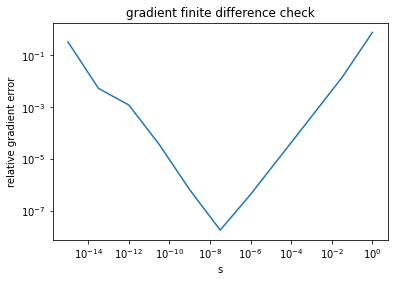

In [26]:
plt.figure()
plt.loglog(ss, grad_errs)
plt.title('gradient finite difference check')
plt.xlabel('s')
plt.ylabel('relative gradient error')

u0_2 = fenics.Function(V)
u0_2.vector()[:] = np.random.randn(V.dim())
dg = apply_hessian(u0_2.vector() - u0.vector())
g2 = gradient(u0_2.vector())
dg_diff = g2 - g
hess_err = fenics.norm(dg - dg_diff) / fenics.norm(dg_diff)
print('hess_err=', hess_err)

## Visualize Hessian impulse responses

$$g \mapsto M^{-1} H M^{-1} g$$

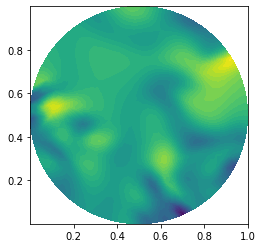

In [27]:
g = fenics.Function(V)
g.vector()[:] = np.random.randn(V.dim())

Hg = fenics.Function(V) 
Hg.vector()[:] = solve_M(apply_Hd(solve_M(g.vector())))

fenics.plot(Hg)

Text(0.5, 1.0, 'point source at [0.2 0.5]')

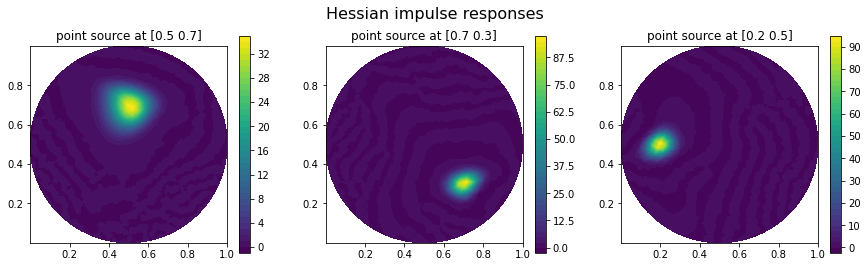

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle('Hessian impulse responses', fontsize=16)

plt.sca(axes[0])
pp = np.array([[0.5,0.7]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[1])
pp = np.array([[0.7,0.3]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[2])
pp = np.array([[0.2,0.5]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_Hd, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

making mass matrix and solver
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
done
getting nodes on boundary
done
computing inds of points far from boundary
done


/home/nick/repos/localpsf/code/localpsf_helpers.py:65: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :], mu_perm[x_ind, :],


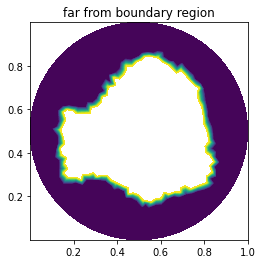

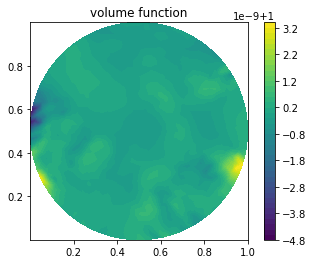

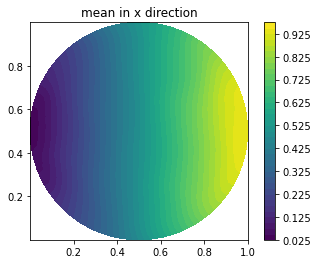

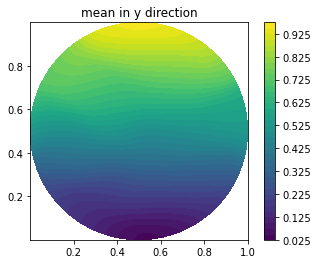

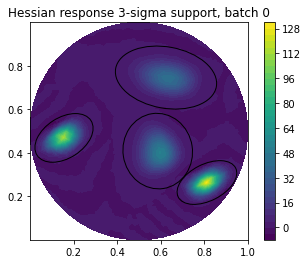

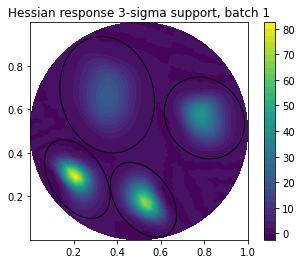

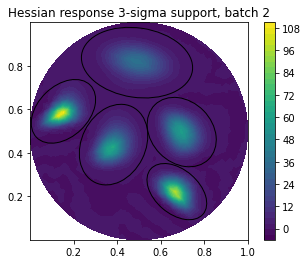

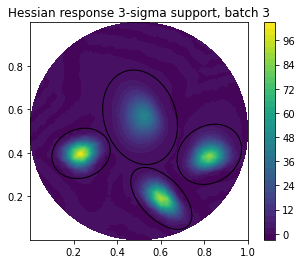

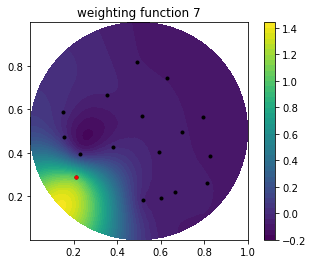

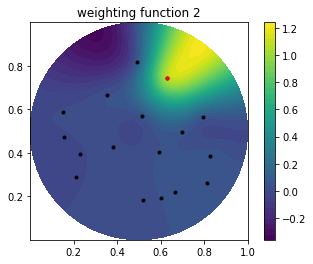

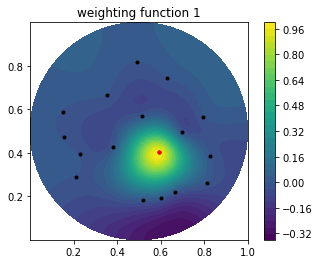

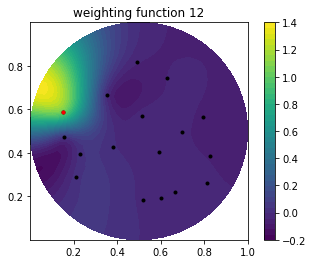

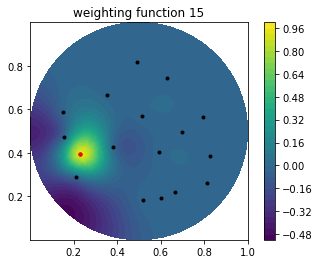

In [29]:
lpsf = LocalPSF(apply_Hd, apply_Hd_t, V, max_batches=4)

lpsf.make_plots()

In [30]:
N = 123456
pp = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)
qq = mesh_center.reshape((1,-1)) + np.random.randn(N, 2)

t = time()
zz_cpp = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_cpp = time() - t
print('dt_cpp=', dt_cpp)

t = time()
zz_py = lpsf.old_evaluate_approximate_hessian_entries_at_points_yy_xx(pp, qq)
dt_py = time() - t
print('dt_py=', dt_py)

bpc_cpp_err = np.linalg.norm(zz_cpp - zz_py) / np.linalg.norm(zz_py)
print('bpc_cpp_err=', bpc_cpp_err)

dt_cpp= 0.7619640827178955
dt_py= 0.11737370491027832
bpc_cpp_err= 0.0


err_Phi2= 0.1626164660642345


Text(0.5, 1.0, 'Phi_true')

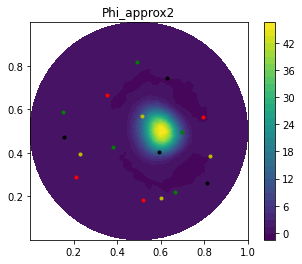

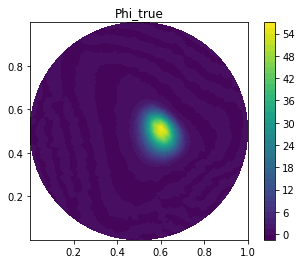

In [31]:
pp = X
q0 = np.array([[0.60,0.50]])
qq = np.dot(np.ones((X.shape[0],1)), q0)

Phi_true = get_hessian_dirac_comb_response(q0, V, apply_Hd, solve_M)

Phi_approx2 = fenics.Function(V)
Phi_approx2.vector()[:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)

err_Phi2 = fenics.norm(Phi_approx2.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi2=', err_Phi2)

plt.figure()
cm = fenics.plot(Phi_approx2)
plt.colorbar(cm)
plt.title('Phi_approx2')

# for x in lpsf.PSI.points:
#     plt.plot(x[0], x[1], '.r')
pp = lpsf.point_batches[0]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.k')
    
pp = lpsf.point_batches[1]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.r')
    
pp = lpsf.point_batches[2]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.g')
    
pp = lpsf.point_batches[3]
for k in range(pp.shape[0]):
    plt.plot(pp[k,0], pp[k,1], '.y')

plt.figure()
cm = fenics.plot(Phi_true)
plt.colorbar(cm)
plt.title('Phi_true')

In [32]:
cluster_tree = hpro.build_cluster_tree_from_dof_coords(X, 60)
block_cluster_tree = hpro.build_block_cluster_tree(cluster_tree, cluster_tree, 2.0)

Hd_hmatrix = lpsf.build_hmatrix(tol=1e-8, block_cluster_tree=block_cluster_tree, symmetrize=True)
# Hd_hmatrix = lpsf.build_hmatrix(tol=1e-8, symmetrize=True)
ct = Hd_hmatrix.row_ct()
bct = Hd_hmatrix.bct
# hpro.visualize_cluster_tree(ct, "heat_inverse_problem_cluster_tree")
# hpro.visualize_block_cluster_tree(bct, "heat_inverse_problem_block_cluster_tree")
# hpro.visualize_hmatrix(Hd_hmatrix, "heat_inverse_problem_hmatrix")

building ProductConvolutionCoeffFn
done
building A0 hmatrix
done
building M hmatrix
done
computing A_hmatrix = A_hmatrix * M_hmatrix
done
computing A_hmatrix = M_hmatrix * A_hmatrix
done


In [33]:
# Hd_hmatrix_T = Hd_hmatrix.T
#
# z1 = np.random.randn(Hd_hmatrix.shape[1])
# z2 = np.random.randn(Hd_hmatrix_T.shape[1])
#
# err_transpose = np.dot(z2, Hd_hmatrix.matvec(z1)) - np.dot(Hd_hmatrix_T.matvec(z2), z1)
# print('err_transpose=', err_transpose)
#
# q1 = Hd_hmatrix.matvec(z1)
# q2 = Hd_hmatrix_T.matvec(z1)
#
# nonsymmetry = np.linalg.norm(q1-q2)/np.linalg.norm(q1)
# print('nonsymmetry=', nonsymmetry)
#
# Hd_hmatrix_sym = Hd_hmatrix.sym(rtol=1e-10)
#
# err_symmetrize = np.dot(z2, Hd_hmatrix_sym.matvec(z1)) - np.dot(Hd_hmatrix_sym.matvec(z2), z1)
# print('err_symmetrize=', err_symmetrize)


err_hmatvec= 1.0


Text(0.5, 1.0, 'error (difference)')

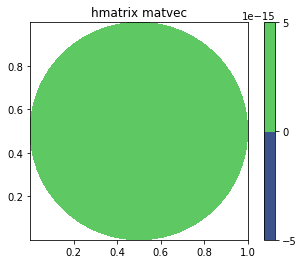

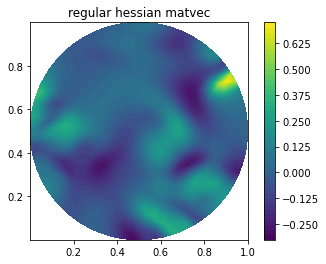

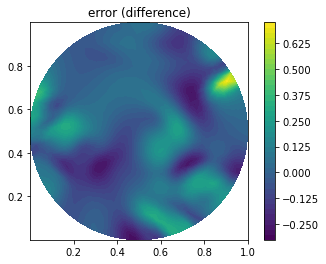

In [34]:
z = fenics.Function(V)
z.vector()[:] = np.random.randn(X.shape[0])

v = fenics.Function(V)
# v.vector()[:] = hpro.hmatrix_matvec(A_hmatrix, ct, ct, (M * z.vector())[:])
v.vector()[:] = Hd_hmatrix * (M * z.vector())[:]

v2 = fenics.Function(V)
v2.vector()[:] = solve_M(apply_Hd(z.vector()))

err_hmatvec = np.linalg.norm(v.vector()[:] - v2.vector()[:])/np.linalg.norm(v2.vector()[:])
print('err_hmatvec=', err_hmatvec)

cm1 = fenics.plot(v)
plt.colorbar(cm1)
plt.title('hmatrix matvec')

plt.figure()
cm2 = fenics.plot(v2)
plt.colorbar(cm2)
plt.title('regular hessian matvec')

plt.figure()
cm3 = fenics.plot(v2 - v)
plt.colorbar(cm3)
plt.title('error (difference)')

In [35]:
def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = fenics.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [36]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)

K_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(K)
M_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

R0_csc = K_csc + reg_M_scalar*M_csc
R_csc = a_reg * R0_csc

In [ ]:
# M_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(M_csc, bct)
R0_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(R0_csc, bct)

R_hmatrix = R0_hmatrix * a_reg

hpro.visualize_hmatrix(R_hmatrix, "heat_inverse_problem_R_hmatrix")

In [ ]:
x = np.random.randn(V.dim())
y1 = R_csc * x
y2 = R_hmatrix * x
err_R_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_R_hmatrix=', err_R_hmatrix)

In [ ]:
# x = np.random.randn(V.dim())
# y1 = M_csc * x
# y2 = M_hmatrix * x
# err_M_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
# print('err_M_hmatrix=', err_M_hmatrix)

In [ ]:
def apply_H(x_vec):
    x = fenics.Function(V)
    x.vector()[:] = x_vec
    y_vec = apply_Hd(x.vector())[:] + a_reg*(R_csc*x_vec)
    return y_vec

H_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

In [ ]:
R_scale_err = np.linalg.norm((a_reg * R_hmatrix) * x - a_reg * R_csc * x)
print('R_scale_err=', R_scale_err)

In [ ]:
H_hmatrix = Hd_hmatrix + a_reg * R_hmatrix

hpro.visualize_hmatrix(H_hmatrix, "heat_inverse_problem_H_hmatrix_sym")

In [ ]:
x = np.random.randn(V.dim())
y1 = H_hmatrix * x
y2 = M_csc * (Hd_hmatrix * (M_csc * x)) + a_reg * (R0_csc * x)
np.linalg.norm(y2-y1)/np.linalg.norm(y2)

In [ ]:
iH_hmatrix = H_hmatrix.factorized_inverse()

In [ ]:
err_H_matrix_factorization = np.linalg.norm(x - H_hmatrix * iH_hmatrix.matvec(x))/np.linalg.norm(x)
print('err_H_matrix_factorization=', err_H_matrix_factorization)

In [ ]:
krylov_iter=5
krylov_tol=1e-12

# Hfull_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=apply_H)

solve_R = spla.factorized(a_reg * R_csc)
solve_R_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=solve_R)

solve_M = spla.factorized(M_csc)
solve_M_linop = spla.LinearOperator((V.dim(), V.dim()), matvec=solve_M)

b = np.random.randn(V.dim())
# x_true = np.linalg.solve(H_true, b)

x_M = spla.gmres(H_linop, b, M=solve_M_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_mass = np.linalg.norm(apply_H(x_M) - b)/np.linalg.norm(b)
print('err_mass=', err_mass)

x_R = spla.gmres(H_linop, b, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(apply_H(x_R) - b)/np.linalg.norm(b)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_linop, b, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(apply_H(x_pre) - b)/np.linalg.norm(b)
print('err_pre=', err_pre)

In [ ]:
z0 = fenics.Function(V)

g_dual = gradient(z0.vector())
g = g_dual[:]
g_reisz = fenics.Function(V)
g_reisz.vector()[:] = solve_M(g_dual)

fenics.plot(u0_true, cmap='gray')
plt.title('u0_true')

plt.figure()
fenics.plot(-g_reisz, cmap='gray')
plt.title('-gradient at zero')

In [ ]:
u0_exact = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=50, maxiter=1, tol=krylov_tol)[0]
u0_err_exact = np.linalg.norm(apply_H(u0_exact) + g)/np.linalg.norm(g)
print('u0_err_exact=', u0_err_exact)

u0_exact_fct = fenics.Function(V)
u0_exact_fct.vector()[:] = u0_exact
fenics.plot(u0_exact_fct, cmap='gray')
plt.title('u0_exact_fct')

uf_fct = fenics.Function(V)
uf_fct.vector()[:] = forward_map(u0_exact_fct.vector())

uf_true_fct = fenics.Function(V)
uf_true_fct.vector()[:] = forward_map(u0_true.vector())

In [ ]:
morozov_discrepancy = np.sqrt(fenics.assemble((uf_true_fct - uf_fct)**2 * fenics.dx))
obs_norm = np.sqrt(fenics.assemble(uf_true_fct**2 * fenics.dx))
morozov_relative_noise_level = morozov_discrepancy / obs_norm

print('morozov_discrepancy=', morozov_discrepancy, ', obs_norm=', obs_norm)
print('morozov_relative_noise_level=', morozov_relative_noise_level)

In [ ]:
krylov_iter=15
krylov_tol=1e-12

u0_none = spla.gmres(H_linop, -g, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_none = np.linalg.norm(apply_H(u0_none) + g)/np.linalg.norm(g)
print('u0_err_none=', u0_err_none)

u0_R = spla.gmres(H_linop, -g, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_reg = np.linalg.norm(apply_H(u0_R) + g)/np.linalg.norm(g)
print('u0_err_reg=', u0_err_reg)

u0_pre = spla.gmres(H_linop, -g, M=iH_hmatrix, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_pre = np.linalg.norm(apply_H(u0_pre) + g)/np.linalg.norm(g)
print('u0_err_pre=', u0_err_pre)

plt.figure()
u0_none_fct = fenics.Function(V)
u0_none_fct.vector()[:] = u0_none
fenics.plot(u0_none_fct, cmap='gray')
plt.title('u0_none_fct')

plt.figure()
u0_R_fct = fenics.Function(V)
u0_R_fct.vector()[:] = u0_R
fenics.plot(u0_R_fct, cmap='gray')
plt.title('u0_R_fct')

plt.figure()
u0_pre_fct = fenics.Function(V)
u0_pre_fct.vector()[:] = u0_pre
fenics.plot(u0_pre_fct, cmap='gray')
plt.title('u0_pre_fct')

In [ ]:
A_linop = spla.LinearOperator(H_linop.shape,
                              matvec=lambda x:iH_hmatrix.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(iH_hmatrix.matvec(x))-x)

AR_linop = spla.LinearOperator(H_linop.shape,
                              matvec=lambda x:solve_R_linop.matvec(H_linop.matvec(x))-x,
                              rmatvec=lambda x: H_linop.matvec(solve_R_linop.matvec(x))-x)

_,ss,_ = basic_randomized_svd(A_linop, 100)
_,ssR,_ = basic_randomized_svd(AR_linop, 100)

In [ ]:
plt.figure()
plt.semilogy(ss)
plt.semilogy(ssR)
plt.legend(['ss', 'ssR'])
plt.title('preconditioned singular values')

In [ ]:
ss